# Final Project in DATA102

**Members:**


1.   Eric Yao
2.   Matthew Cuaresma
3. Aubrei Siababa
4. Marc Que
5. Gwendolyn Ang


## **Problem Statement:**
Grand View Research (2024) pegged the global anime market size to be $31.23 billion with a compound annual growth rate in the next 6 years to be 9.8%. What was once a niche interest among “socially awkward misfits” has now grown more mainstream on and offline, making record-setting profits in cinema opening weekends comparable to Batman movies, while raking in viewers on on online streaming sites. The latter is especially relevant as it became people’s primary source of entertainment during the COVID pandemic.

Brzeksi (2021) reports that, *“In 2021, over half of all Netflix subscribers worldwide watched at least some anime content on the platform.”* Netflix is just one of many sites users can turn to for their binge-watching fix encompassing both anime websites like Animefreak.tv, Contv.com and AsianCrush as well as US streaming platforms like Amazon Prime and Hulu. Regardless, these platforms are limited in their selections. From over 12,000 possible shows, Netflix, Cruncyroll, and Funimation offer only 160, 1,000 and 600 titles which means that their recommender systems cannot make the most optimal recommendation for users.

This limitation is compounded by several issues:

**Redundancy**: The sheer volume of new anime released each season often leads to repetitive content, making it difficult for users to discover unique shows that align with their tastes.

**Tediousness**: Users must invest significant time and effort into researching and sifting through recommendations, which can be a cumbersome process.

**Outdatedness**: Existing recommendation systems and crowdsourced efforts, like genre-based flowcharts, often become outdated, failing to incorporate the latest titles and trends.

While there have been previous attempts to develop anime recommender systems, most have relied on collaborative filtering, which comes with certain limitations:


> **AniReco (Ota et al., 2017):** This system uses collaborative filtering, focusing on the usability of the search process and providing a visual exploratory performance. The network diagram approach used in AniReco is noted for its ability to help users recognize differences in recommendation rank and explore various works. However, it primarily focuses on proximity, which may limit the diversity of recommendations.



> **Deep Learning Recommender System for Anime (Mutteppagol, 2021):** Similar to AniReco, this system also employs collaborative filtering. It generates top recommendations for users based on predicted ratings. While effective in providing personalized recommendations, it shares the inherent biases of collaborative filtering, such as the popularity bias and cold start problem, where new or less popular anime may not be recommended as often.


> **RikoNet (Soni et al., 2023):** This system introduces a hybrid approach by using deep autoencoders to predict ratings and generate embeddings. These embeddings are then used to form clusters of similar anime titles based on user preferences. RikoNet combines predicted ratings with cluster-based similarities to create its hybrid filter, aiming to enhance recommendation accuracy by leveraging both collaborative and content-based elements.

Most existing systems, such as AniReco and the Deep Learning Recommender System, rely heavily on collaborative filtering, which is known to be prone to popularity bias and the cold start problem.

To address these challenges, this project aims to develop an advanced anime recommendation system using both content-based filtering and collaborative filtering techniques. The goal is to analyze the similarities between anime that users have enjoyed and the extensive database of anime titles, producing personalized recommendations. By employing and comparing these two filtering approaches, the project seeks to determine which method yields more accurate and user-satisfactory recommendations.



## **Data Collection**

Data was collected from https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset. To load the data eaier, we utilized Git LFS to store the files. The raw data is accesssible in this [repository](https://github.com/jinzalabim/DATA102-Final-Project).


# Importing Libraries

In [1]:
!pip install pyfim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyfim: filename=pyfim-6.28-cp310-cp310-linux_x86_64.whl size=644210 sha256=3aa08c9f30b0a199d962e001388c2f6682bab5d2382101dc05807968c494e0a2
  Stored in directory: /root/.cache/pip/wheels/96/0a/b3/c877bfa85c4cfe1baf3de4a89e1949382be09de5eabe49314f
Successfully built pyfim


In [2]:
pip install fuzzywuzzy

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from fim import arules, apriori, fpgrowth
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import pearsonr

import json
from fuzzywuzzy import process
from sklearn.metrics.pairwise import cosine_similarity

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
# Load the data
df = pd.read_csv('https://media.githubusercontent.com/media/jinzalabim/DATA102-Final-Project/main/anime-dataset-2023-unknownsremoved.csv')
df.head(5)

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Source,Duration,Duration (mins),Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,33187,Katsudou Shashin,UNKNOWN,æ´»å‹•å†™çœŸ,5.46,UNKNOWN,A young boy dressed in sailor attire and a bri...,Movie,1,Not available,...,Original,3 sec,0,G - All Ages,10898,6792,23,4458,7548,https://cdn.myanimelist.net/images/anime/1891/...
1,38058,Oi-san to 40 no Monogatari,UNKNOWN,ã‚ªã‚¤ã•ã‚“ã¨40ã®ç‰©èªž,5.45,Slice of Life,Fourty shorts featuring a delightfully chubby ...,ONA,41,"Mar 26, 2018 to Sep 19, 2018",...,Original,6 sec per ep,0,G - All Ages,10942,17209,0,103,301,https://cdn.myanimelist.net/images/anime/1760/...
2,41097,Motto Shitte Fukushima!,UNKNOWN,ã‚‚ã£ã¨ çŸ¥ã£ã¦ ãµãã—ã¾ï¼,UNKNOWN,Slice of Life,Tourism promotional videos for the Fukushima P...,ONA,84,"Feb 18, 2019 to Jan 17, 2020",...,Original,6 sec per ep,0,G - All Ages,18287,19602,0,UNKNOWN,158,https://cdn.myanimelist.net/images/anime/1711/...
3,53291,Terada Mokei Ã— Pocari Sweat,UNKNOWN,ãƒ†ãƒ©ãƒ€ãƒ¢ã‚±ã‚¤ Ã— ãƒã‚«ãƒªã‚¹ã‚¨ãƒƒãƒˆ,UNKNOWN,Slice of Life,Genki-kun's life as a thirsty Japanese salaryman.,ONA,9,"Jun 13, 2013 to Sep 24, 2013",...,Original,6 sec per ep,0,G - All Ages,12887,22274,0,UNKNOWN,58,https://cdn.myanimelist.net/images/anime/1844/...
4,32294,Ai (ONA),UNKNOWN,æ„›,2.63,Romance,The circumstances responsible for the person's...,ONA,1,10-Aug-12,...,Original,7 sec,0,G - All Ages,12693,8440,8,2883,4339,https://cdn.myanimelist.net/images/anime/3/774...


# Data Preprocessing

In [5]:
#Unknown Values
df.replace('UNKNOWN', np.nan, inplace=True)
df.drop(columns=['Image URL'], inplace=True)

In [6]:
# Correct text encoding issues
df['Name'] = df['Name'].str.replace('[^\x00-\x7F]+', '', regex=True)
df['Other name'] = df['Other name'].str.replace('[^\x00-\x7F]+', '', regex=True)

In [7]:
numeric_cols = ['Score', 'Rank', 'Popularity', 'Favorites', 'Scored By', 'Members', 'Duration (mins)']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [8]:
# function to find the closest anime by 'Popularity' and impute missing values
def impute_values(df):
    df_copy = df.copy()
    for index, row in df.iterrows():
        #drop the rows with NaN values, so they won't participate in the popularity similarity calculation
        columns_to_check = ['Score', 'Scored By', 'Rank']
        df_cleaned = df.dropna(subset=columns_to_check)
        if pd.isna(row['Score']) or pd.isna(row['Scored By']) or pd.isna(row['Rank']):
            closest_index = (df_cleaned['Popularity'] - row['Popularity']).abs().argsort()[1]
            closest_anime = df.iloc[closest_index]
            df_copy.at[index, 'Score'] = closest_anime['Score']
            df_copy.at[index, 'Scored By'] = closest_anime['Scored By']
            df_copy.at[index, 'Rank'] = closest_anime['Rank']
    return df_copy

In [9]:
# function to find the closest anime by 'Popularity' and impute missing values
def impute_values(df):
    df_copy = df.copy()
    for index, row in df.iterrows():
        #drop the rows with NaN values, so they won't participate in the popularity similarity calculation
        columns_to_check = ['Score', 'Scored By', 'Rank']
        df_cleaned = df.dropna(subset=columns_to_check)

        closest_index = (df_cleaned['Popularity'] - row['Popularity']).abs().argsort()[1]
        closest_anime = df.iloc[closest_index]

        if pd.isna(row['Score']):
            df_copy.at[index, 'Score'] = closest_anime['Score']
        elif pd.isna(row['Scored By']):
            df_copy.at[index, 'Scored By'] = closest_anime['Scored By']
        elif pd.isna(row['Rank']):
            df_copy.at[index, 'Rank'] = closest_anime['Rank']
    return df_copy

In [10]:
df = impute_values(df)
df.to_csv('imputed_df.csv')

## Fixing Categorical Data

We did this so that the categorical columns 'Type' and 'Rating' are converted into a one-hot encoded format ++ the original categorical columns are removed and replaced with the above.

In [11]:
categorical_cols = ['Type', 'Rating']
one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_features = one_hot_encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(categorical_cols))
df = pd.concat([df, encoded_df], axis=1)
df.drop(columns=categorical_cols, inplace=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
# Preprocess Synopsis
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
synopsis_tfidf = vectorizer.fit_transform(df['Synopsis'].fillna(''))
synopsis_df = pd.DataFrame(synopsis_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

## Data Aggregation

In [13]:
#Fix numerical columns
numerical_cols = ['Score', 'Rank', 'Popularity', 'Favorites', 'Scored By', 'Members', 'Duration (mins)']
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(df[numerical_cols])
normalized_df = pd.DataFrame(normalized_features, columns=numerical_cols)

In [14]:
# Process Genres column into multiple binary columns
df['Genres'] = df['Genres'].fillna('')
genres = df['Genres'].str.get_dummies(sep=', ')

In [15]:
# Combine all features into a single dataframe
processed_df = pd.concat([df[['anime_id', 'Name']], encoded_df, normalized_df, genres, synopsis_df], axis=1)

print(processed_df.head())
print(df.describe())

   anime_id                        Name  Type_Movie  Type_Music  Type_ONA  \
0     33187            Katsudou Shashin         1.0         0.0       0.0   
1     38058  Oi-san to 40 no Monogatari         0.0         0.0       1.0   
2     41097     Motto Shitte Fukushima!         0.0         0.0       1.0   
3     53291  Terada Mokei  Pocari Sweat         0.0         0.0       1.0   
4     32294                    Ai (ONA)         0.0         0.0       1.0   

   Type_OVA  Type_Special  Type_TV  Type_nan  Rating_G - All Ages  ...  women  \
0       0.0           0.0      0.0       0.0                  1.0  ...    0.0   
1       0.0           0.0      0.0       0.0                  1.0  ...    0.0   
2       0.0           0.0      0.0       0.0                  1.0  ...    0.0   
3       0.0           0.0      0.0       0.0                  1.0  ...    0.0   
4       0.0           0.0      0.0       0.0                  1.0  ...    0.0   

   work  working  works  world      year  years   

# Exploratory Data Analysis

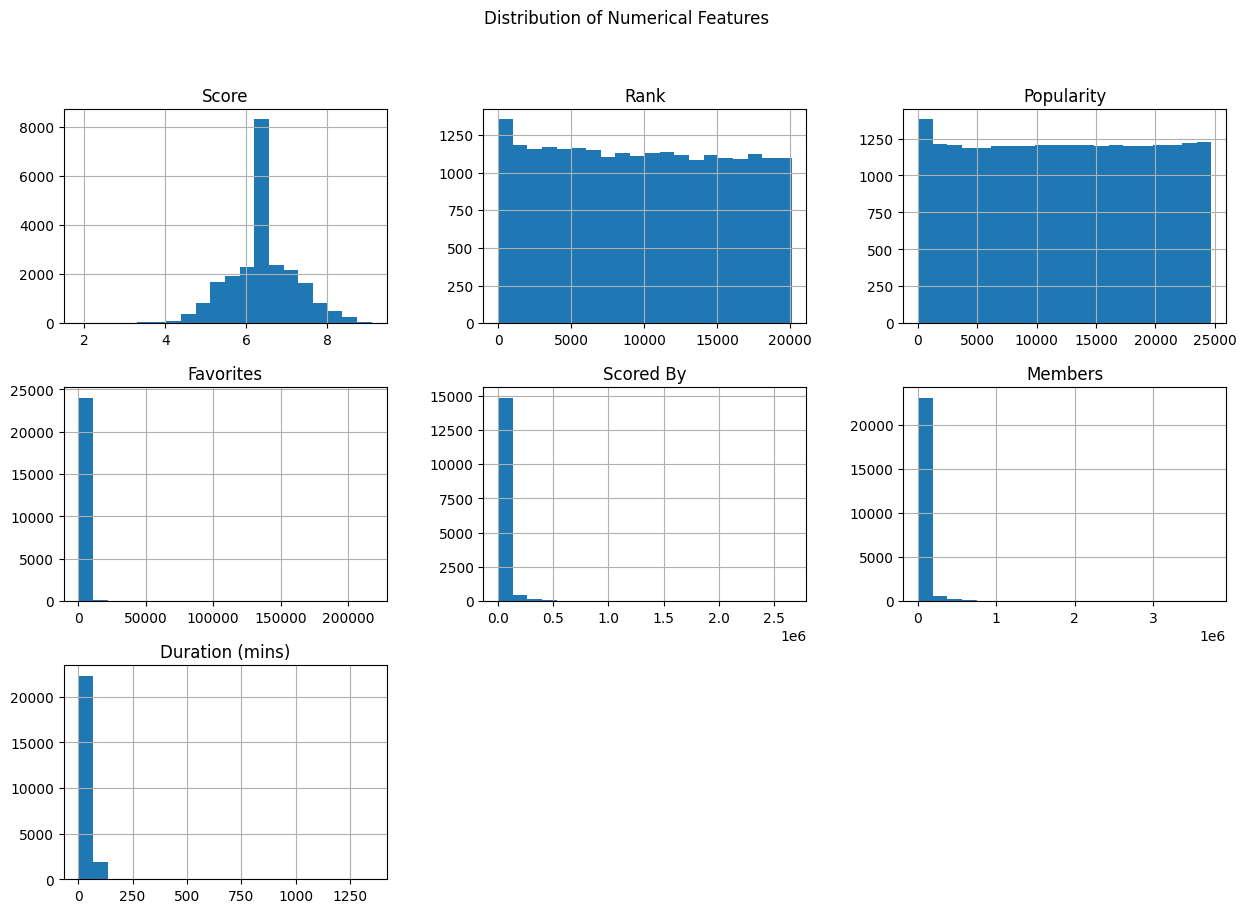

In [16]:
#Distribution of Numerical Features
numerical_cols = ['Score', 'Rank', 'Popularity', 'Favorites', 'Scored By', 'Members', 'Duration (mins)']
df[numerical_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features')
plt.show()

<ipython-input-17-4ecf55077d4d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tfidf_feature_importance.values, y=tfidf_feature_importance.index, palette='viridis')


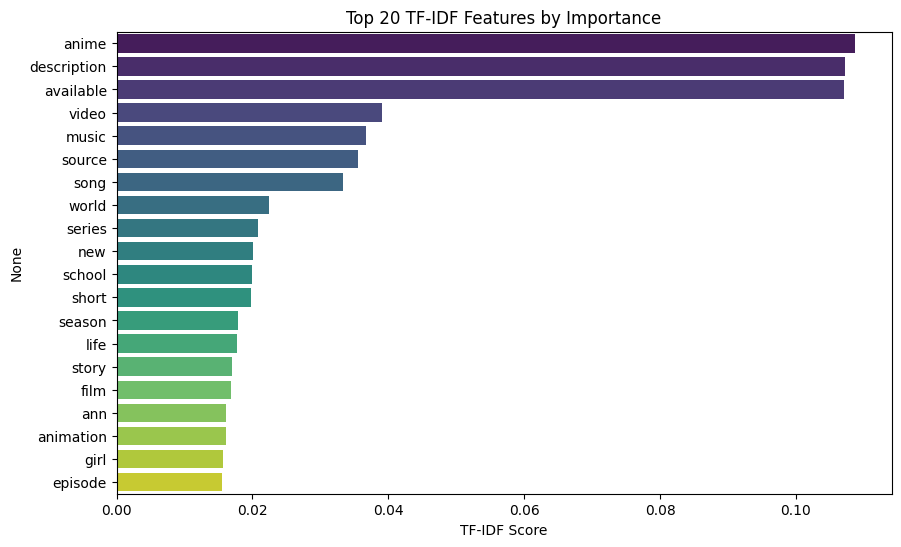

In [17]:
#TF-IDF Feature Analysis
tfidf_feature_importance = synopsis_df.mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=tfidf_feature_importance.values, y=tfidf_feature_importance.index, palette='viridis')
plt.title('Top 20 TF-IDF Features by Importance')
plt.xlabel('TF-IDF Score')
plt.show()

In case we need EDA for Distribution for Categorical Features:



```
#Distribution of Categorical Features
categorical_features = one_hot_encoder.get_feature_names_out(categorical_cols)
for col in categorical_features:
    sns.countplot(y=df[col], palette="viridis")
    plt.title(f'Distribution of {col}')
    plt.show()
```



In [18]:
# DONT MIND STILL TESTING
'''
corr_matrix = processed_df.corr(method='pearson', numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()
'''

"\ncorr_matrix = processed_df.corr(method='pearson', numeric_only=True)\nplt.figure(figsize=(12, 10))\nsns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)\nplt.title('Correlation Matrix')\nplt.show()\n"

# Content-based Filtering Function


In [19]:
def content_based(user_id,mean_sub=0):
    global anime_df
    global user_df

    #make the item matrix
    df_item = anime_df.drop(['Name'], axis=1).set_index('anime_id')

    #extract the user rating to add weights to each anime feature
    user_ratings = user_df.query(f"user_id=={user_id}")['rating']

    #construct the item profile based on the rating of the user
    user_watched = user_df.query(f"user_id=={user_id}")['anime_id']
    df_item_rated = df_item.loc[user_watched] * user_ratings.values.reshape(-1, 1)
    df_item_rated = df_item_rated.replace(0, np.nan)

    #if mean_subtraction was used to get the user profile
    if mean_sub == 1:
        df_item_rated = df_item_rated - user_ratings.mean()

    #computing for the user profile
    user_profile_rated = df_item_rated.mean(axis=0)
    user_profile_rated = user_profile_rated.fillna(0)

    #compute for the similarities
    df_scores_rated = anime_df.copy()
    scores = cosine_similarity(df_item, user_profile_rated.values.reshape(1,-1)).reshape(-1)
    df_scores_rated['similarity'] = scores

    #sort out the most similar items
    df_scores_sorted = df_scores_rated.sort_values('similarity', ascending=False)
    #exclude those that have been watched by the user and display as output
    df_scores_filtered = df_scores_sorted.query(f"anime_id not in {user_watched.values.tolist()}")

    output_df = df_scores_filtered.head(10)
    #output
    return print(output_df[['anime_id', 'Name', 'similarity']])

# Collaborative filtering (user-based)

In [25]:
# get average rating
def get_weighted_similarity(x,similar_users):
    weighted_similarity = x * similar_users
    norm = similar_users[~weighted_similarity.isna()].sum()
    rating = weighted_similarity.sum()/norm
    warnings.filterwarnings("ignore")
    return rating

def user_based(user_id):
    global anime_df
    global user_df

    #build user matrix
    user_df['rating'].astype(float)
    user_item_matrix = user_df.pivot(index='user_id', columns='anime_id', values='rating')

    #retrieve k most similar users
    df_user_filled = user_item_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

    k = 3
    #reference user ratings
    reference_user = df_user_filled.loc[user_id].values.reshape(1, -1)

    user_similarities = df_user_filled.apply(lambda x: cosine_similarity(x.values.reshape(1, -1), reference_user)[0,0], axis=1)

    similar_users = user_similarities.drop(user_id, axis=0).nlargest(k)


    #REINDEXING SOLUTION
    # Filter the user_item_matrix to only include items that exist in both DataFrames
    common_users = user_item_matrix.index.intersection(similar_users.index)

    # Reindex the user_item_matrix to ensure only valid indices are accessed
    valid_user_item_matrix = user_item_matrix.reindex(common_users)

    #compute the average weighted ratings
    predicted_ratings = valid_user_item_matrix.T.apply(lambda x: get_weighted_similarity(x, similar_users), axis=1)
    #print([predicted_ratings])

    predicted_ratings = predicted_ratings.sort_values(ascending=False)

    #get items that the user has not watched yet
    user_unrated_items = user_item_matrix.loc[user_id].isna()

    #output
    recommended_items = predicted_ratings[user_unrated_items].head(10)

    #find the name of the anime for those outputs that has a non-null output
    non_null_indices = recommended_items[recommended_items.notnull()].index
    anime_names = anime_df[anime_df['anime_id'].isin(non_null_indices)]['Name'].tolist()

    #combine the anime name with the score
    recommended_anime = pd.DataFrame({
        'Anime Name': anime_names,
        'Score': recommended_items[recommended_items.notnull()]
        })

    return print(recommended_anime)

# User Interface Construction

## Functions

In [21]:
# Function to load user profiles from a file
def load_user_df(file_path):
    global user_df
    try:
        user_df = pd.read_csv(file_path)
        print("User profiles loaded successfully.")
    except FileNotFoundError:
        print("No existing user profiles found. Starting with an empty DataFrame.")

# Function to find the closest matching anime title
def find_anime(title, anime_df):
    choices = anime_df['Name'].tolist()
    match = process.extractOne(title, choices)
    return match

# Function to check if the user profile exists
def check_user():
    global user_df
    user_id = int(input("Enter existing user ID: "))

    if user_id in user_df['user_id'].values:
        user_row = user_df[user_df['user_id'] == user_id]
        print(f"Selected user ID {user_id} with name {user_row['Username'].values[0]}.")
        return [user_id, True]
    else:
        print(f"User ID {user_id} does not exist.")
        return [user_id,False]

# Function to add rating to an anime for a user
def add_rating(user_id, anime_title, rating, user_name):
    global user_df
    global anime_df

    # Find the anime
    match = find_anime(anime_title, anime_df)
    if match:
        matched_title = match[0]
        matched_index = anime_df[anime_df['Name'] == matched_title].index[0]

        new_rating = pd.DataFrame({
            'user_id': [user_id],
            'Username': [user_name],
            'anime_id':[matched_index],
            'Anime Title': [matched_title],
            'rating': [rating]})
        user_df = pd.concat([user_df, new_rating], ignore_index=True)

        print(f"Added rating {rating} for anime '{matched_title}' for user ID {user_id}.")
    else:
        print(f"No matching anime found for title '{anime_title}'.")

# Function to save user profiles to a file
def save_user_df():
    user_df.to_csv('user_df.csv')
    print("User profiles saved successfully.")

# User interface to create/select profile and add ratings
def user_interface():
    global user_df
    global anime_df

    while True:
        print("\nOptions:")
        print("1. Add rating to an anime")
        print("2. Get anime recommendation")
        print("3. Save and exit")
        choice = input("Enter your choice: ")

        load_user_df('user_df.csv')

        if choice == '1':
            #check if the user is new. If yes, we need the user to select a user name
            user_id_check = check_user()
            if user_id_check[1] == False:
                print('It looks like you do not have an account yet...')
                user_name = input("Enter username: ")
            elif user_id_check[1] == True:
                user_id = user_id_check[0]
                user_name = user_df.loc[user_df['user_id'] == user_id, 'Username'].values[0]

            #select the anime title to be rated
            anime_title = input("Enter anime title: ")
            rating = int(input("Enter rating: "))

            add_rating(user_id_check[0], anime_title, rating, user_name)

            save_user_df()

        elif choice == '2':
            user_id = check_user()[0]
            print('Recommended anime using content-based filtering:')
            content_based(user_id)

            print('\nRecommended anime using collaborative filtering:')
            user_based(user_id)

        elif choice == '3':
            save_user_df()
            break

        else:
            print("Invalid choice. Please try again.")


## Full user data

In [22]:
#Full user data
full_user_df = pd.read_csv('https://media.githubusercontent.com/media/jinzalabim/DATA102-Final-Project/main/users-score-2023.csv')

In [23]:
#anime dataset
anime_df = processed_df.fillna(0)

#shortened user data with only user ids 1 to 20 to avoid crashing
#NOTE: running this code will erase new user data
user_df = full_user_df[full_user_df['user_id'].between(1, 10000)]
user_df.to_csv('user_df.csv')

# Main Interactive Section: User Interface

In [ ]:
# Run the user interface
user_interface()


Options:
1. Add rating to an anime
2. Get anime recommendation
3. Save and exit


# Other Data Acquisition

In [ ]:
#Number of anime User 1 has watched and rated
U1_anime = user_df[user_df['user_id']==1]['Anime Title'].tolist()
print('User 1 has watched',len(U1_anime), 'anime.')
U1_anime[:10]

# **Conclusion and Recommendations**

## Conclusion
The project's goal was to create a customized anime recommendation system in order to solve the outdated, repetitive, and redundant nature of the current anime recommendation systems. Preprocessing the data, calculating similarity, and producing recommendations based on user preferences were the main processes. The strategy focused on using content-based filtering to get over the popularity bias present in collaborative filtering. In our project, we aimed to develop an efficient anime recommendation system using various filtering techniques. While we successfully implemented content-based filtering and collaborative filtering, there are still some points of improvement.



## Recommendations
**Implement Hybrid Filtering Approach**
> We recommend implementing a hybrid filtering approach that combines the strengths of both content-based filtering and collaborative filtering to create a more robust recommendation system. The content-based filtering component would leverage the metadata of anime titles, such as genres, studios, and producers, to recommend anime similar to what the user has previously enjoyed. Meanwhile, the collaborative filtering component would utilize user behavior, including ratings and viewing history, to identify patterns and recommend anime based on the preferences of users with similar tastes. By integrating both approaches, we can produce recommendations that account for both content features and user behavior. This could be achieved by blending predictions from the two models or by using one method to complement the other, such as employing content-based filtering to address cold-start issues and collaborative filtering to refine the recommendations. To evaluate the effectiveness of this hybrid model, we should compare it with standalone content-based and collaborative filtering models using metrics such as precision, recall, F1-score, coverage, and user satisfaction. We expect the hybrid model to outperform individual methods by addressing their respective limitations, such as collaborative filtering's tendency to recommend overly similar items and content-based filtering's challenges with popularity bias and cold start problems.



**Implement Age-Based Filtering or Weighting**
> Upon reviewing the recommendations generated by user-based collaborative filtering, we noticed a tendency to recommend older anime titles. While these recommendations can be valuable, there is also a need to ensure users are exposed to more recent anime releases. Introduce a filter or weighting system that prioritizes more current anime titles. This can be achieved by assigning a higher weight to anime released within the last few years or by introducing a time decay factor that reduces the relevance of older titles over time.
* ***Customization Option***: Provide users with the ability to set their preference for anime age, allowing them to choose whether they want more recent recommendations, a mix of both old and new, or predominantly older titles.




**Address Computational Limitations**
>Our system struggled to load and process the entire user profile data due to limited computational power. This constraint restricted the scalability and effectiveness of our recommendation system, especially when dealing with large datasets. Transition to a more powerful server or cloud-based infrastructure to handle larger datasets and more complex models. This will enable us to process the full user profile data and enhance the accuracy and efficiency of our recommendations. We can also reiew and optimize the existing codebase to ensure efficient memory and CPU usage. This could involve techniques like batching data, reducing dimensionality, or using more efficient data structures.




**Other Recommendations**
> We recommend enhancing the user profiling system to capture more nuanced preferences, such as specific genres, themes, or even preferred art styles, which would enable the system to provide more personalized recommendations. Additionally, incorporating real-time recommendation updates that adjust based on the user’s most recent interactions could ensure that the system remains responsive to changing preferences, offering a more dynamic and tailored user experience.




# Other Learnings
1. At first it looks easy, but then mid-way of doing the project you go, “whoa it gets complicated”
2. Recommender system can get complex when we want to tailor one model for a specific problem
3. One Piece still goated

# **References**

Brzeski, P. (2022, May 16). How Japanese Anime Became the World’s Most Bankable Genre. The
Hollywood Reporter. Retrieved from. https://www.hollywoodreporter.com/business/business-news/japanese-anime-worlds-most-bankable-genre-1235146810/

Grand View Research (2024). Anime Market Size, Share & Trends Analysis Report By Type (T.V.,
Movie, Video, Internet Distribution, Merchandising, Music), By Genre (Action & Adventure, Sci-Fi & Fantasy, Romance & Drama, Sports, and Others), By Region, And Segment Forecasts, 2024 - 2030. Retrieved from https://www.grandviewresearch.com/industry-analysis/anime-market

Mutteppagol, V. M. (2021). A deep learning recommender system for anime (Doctoral dissertation,
Dublin, National College of Ireland).

Ota, S., Kawata, H., Muta, M., Masuko, S., & Hoshino, J. I. (2017). Anireco: Japanese anime
recommendation system. In Entertainment Computing–ICEC 2017: 16th IFIP TC 14 International Conference, Tsukuba City, Japan, September 18-21, 2017, Proceedings 16 (pp. 400-403). Springer International Publishing.

Soni, B., Thakuria, D., Nath, N., Das, N., & Boro, B. (2023). RikoNet: A Novel Anime Recommendation
Engine. Multimedia Tools and Applications, 82(21), 32329-32348.
